# The Lasso Model

In [1]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import tqdm
from math import sqrt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

df = pd.read_csv('Boliga - Final for training.csv')
df = df.drop(columns = ['Kommune', 'lotSize', 'Relativ Ledighed', 'Total_reported',
                        'Socioeconomic_index', 'expenses_per_school_student',
                       'expenses_sport_and_other_cultural_activities', 'forest_distance',
                       'coast_distance', 'isForeclosure', 'Ejerudgift','buildYear'])

#df_sample = df.sample(500)
pd.options.display.max_columns = None

### Create dummies, and split X and Y

In [2]:
df_dum = pd.get_dummies(df, drop_first = True, columns = ['Type'])
X = df_dum.drop(columns = ['price'])
y = df_dum['price']

### Split into test, dev data

In [3]:
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Train Lasso Regression (K-fold CV)

Now we want to examine whether the a Lasso regression is more appropriate, and seeks to optimize the hyperparameter.
We will train for an optimized hyperparameter on the validation set, to avoid data leakage and use k-fold crossvalidation to make sure that we have not split our dataset in a lucky or unlucky place. 

In [4]:
from sklearn.model_selection import KFold

#Split data into 5 folds
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

#Create Lambda values
lambdas = np.logspace(-1, 7, 15)
# outer loop: lambdas
mseCV = []

for lambda_ in tqdm.tqdm(lambdas):    
    # inner loop: folds
    mseCV_ = []

    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_LassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_LassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_LassoCV.predict(X_val), y_val))

        
    # store result    
    mseCV.append(mseCV_) 
    
# convert to DataFrame
lambda_mseCV_Lasso = pd.DataFrame(mseCV, index=lambdas)

100%|██████████| 15/15 [02:08<00:00,  4.71s/it]


### MSE of the K-fold Crossvalidation - Ridge

Lambda as index

In [5]:
lambda_mseCV_Lasso

,0,1,2,3,4
1.000000e-01,1.853200e+13,1.070435e+12,1.646582e+12,1.122357e+12,3.788891e+11
3.727594e-01,1.858496e+13,1.082469e+12,1.629466e+12,1.123106e+12,3.760618e+11
1.389495e+00,1.874993e+13,1.164050e+12,1.563121e+12,1.128405e+12,3.649738e+11
5.179475e+00,1.933314e+13,1.278344e+12,1.418146e+12,1.141456e+12,3.195700e+11
1.930698e+01,3.310768e+12,1.950098e+12,6.519923e+11,9.124655e+11,2.741861e+11
7.196857e+01,3.493960e+11,3.515937e+11,3.328724e+11,4.788410e+11,1.780972e+11
2.682696e+02,3.528292e+11,2.435445e+11,2.556270e+11,1.831600e+11,9.965698e+10
1.000000e+03,3.245836e+11,5.984594e+10,9.169244e+10,1.502255e+11,7.086657e+10
3.727594e+03,3.060011e+11,6.083629e+10,3.619290e+10,1.109647e+11,7.532624e+10
1.389495e+04,3.116406e+11,5.828025e+10,1.542546e+10,3.847537e+10,6.189877e+10


###  Mean MSE of K-fold CV - Ridge

In [6]:
# Calculates the mean of the folds
mse_mean_Lasso = lambda_mseCV_Lasso.mean(axis = 1)

### Plot Average MSE over Lambda - Ridge

[Text(0, 0.5, 'MSE'), Text(0.5, 0, 'Lambda')]

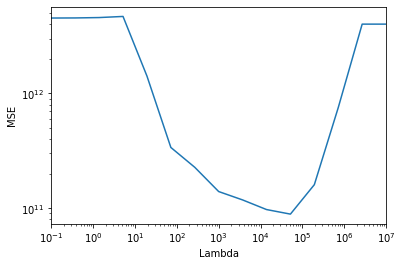

In [7]:
#Plot mean square errors
COL = ['Average MSE']
mse_mean_Lasso.columns = COL

#Both axis are logarythmical 
ax = mse_mean_Lasso.plot(logx = True, logy = True)
ax.set(xlabel = 'Lambda', ylabel = 'MSE')


### Finding the optimal hyperparameter for Lasso

Where was the mean mse smallest?

In [8]:
mse_mean_Lasso.nsmallest(1)

51794.746792    8.863387e+10
dtype: float64

In [9]:
# Optimal lambda is inserted into the Lasso-model
optimal_lambda_Lasso = lambda_mseCV_Lasso.mean(axis=1).nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_LassoCV = make_pipeline(PolynomialFeatures(degree = 3, include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda_Lasso.index[0], random_state=1))
pipe_LassoCV.fit(X_dev,y_dev)

# compare performance by mse
models = {'Lasso CV': pipe_LassoCV}
for name, model in models.items():
    score_mse = mse(model.predict(X_test),y_test)
    score_mae = mae(model.predict(X_test),y_test)
    score_rmse = sqrt(mse(model.predict(X_test),y_test))
    
    print("MSE: " + name, round(score_mse, 2))
    print("RMSE: " + name, round(score_rmse, 2))
    print("MAE: " + name, round(score_mae, 2))

MSE: Lasso CV 20552689386.27
RMSE: Lasso CV 143362.09
MAE: Lasso CV 97693.9


# Learning Curve of Lasso regression:

Since the Lasso regression performed best, we will examine it's performance on out-of-sample data a bit further. 

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_LassoCV,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=5)


mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Validation':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

                    Train    Validation
sample size                            
51           2.034202e+10  2.459304e+11
64           2.115272e+10  1.346678e+11
76           2.246535e+10  1.313388e+11


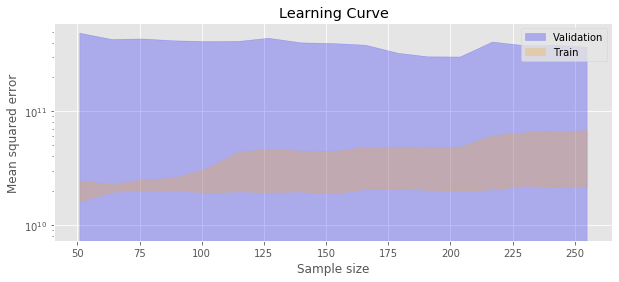

In [11]:
plt.style.use('ggplot')
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Validation', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Sample size')
ax.set_title('Learning Curve')
ax.set_yscale('log')
ax.legend()
f_learn.savefig('Learning curve - Lasso 3 degree.png')

# Validation Curve

Examines the relationsship between how well the model did on the k-fold crossvalidation data, and how well it does on the test data, but for different values of lambda. 

This is a way to visualise how overfit the data is - if the difference is sizeable - and how biased it is - if the MSE is big. 

In [12]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_LassoCV,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=5)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
1000.0    9.753925e+10
Name: Validation, dtype: float64


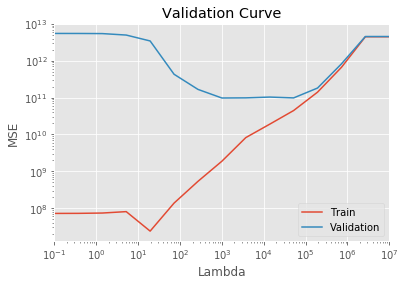

In [13]:
plt.style.use('ggplot')
val_plot = mse_score.plot(logx=True, logy=True, title = 'Validation Curve')
val_plot.set_xlabel('Lambda')
val_plot.set_ylabel('MSE')
val_plot.figure.savefig('Validation Curve - Lasso 3 degree.png')